# "Manual" Neural Networks

Recall that a hypothesis function (i.e. a choice of architecture) $h\colon \mathbb{R}^d \to \mathbb{R}^K$ maps input data to desired outputs. Initially, we used a linear hypothesis class $h_\Theta(\mathbf{x}) = \Theta^\top \mathbf{x}$ where $\Theta \in \mathbb{R}^{d \times K}.$ This forms $K$ linear functions of the input and predicts the class with the largest value. This turns out to be equivalent to partitioning the input space into $K$ linear convex regions corresponding to each class. 

<center><img src="img/03-1.png" width=300></center>

**Remark.** To see this in $\mathbb{R}^2$ with $3$ classes, we have $2$ inequality constraints $\theta_1^\top \mathbf{x} \geq \theta_2^\top \mathbf{x}$ and $\theta_1^\top \mathbf{x} \geq \theta_3^\top \mathbf{x}.$ This resuts in a  convex polyhedron which is the intersection of two linear half-spaces. Similarly, for the other two. It can be shown that the interior of these subsets are disjoint and the union of the three cover all of $\mathbb{R}^2.$

**Q.** What about data that are not linearly separable? We want some way to separate these points via a nonlinear set of class boundaries.

In [1]:
import math
import numpy as np

N = 100
r_eps = 0.3

def circle_data(radius: float, r_eps=r_eps, num_points=N):
    r0 = radius
    t = 2 * math.pi * np.random.random(N)
    r = r0 + r_eps * np.random.randn(N)
    x, y = r * np.cos(t), r * np.sin(t)
    return x, y

x0, y0 = circle_data(3)
x1, y1 = circle_data(5)
x2, y2 = circle_data(1)

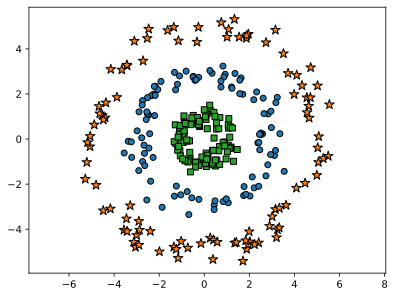

In [2]:
#| code-fold: true
%config InlineBackend.figure_formats = ["svg"] 
import matplotlib.pyplot as plt

plt.scatter(x0, y0, edgecolor="k")
plt.scatter(x1, y1, marker="*", edgecolor="k", s=100)
plt.scatter(x2, y2, marker="s", edgecolor="k")
plt.axis("equal");

## Nonlinear features

**One idea:** Apply a linear classifier to
some (potentially higher-dimensional) *features* of the data:

$$h_\Theta(\mathbf{x}) = \Theta^\top \phi(\mathbf{x})$$ 

where $\Theta \in \mathbb{R}^{n \times K}$ and $\phi\colon \mathbb{R}^d \to \mathbb{R}^n$ is a **feature transformation**. 

**Example.** For the above dataset, we can define $\phi(x, y) = (x, y, x^2 + y^2)$ (i.e. $r^2$) which makes the dataset separable in $\mathbb{R}^3$:

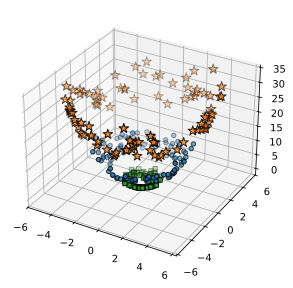

In [3]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x0, y0, x0 ** 2 + y0 ** 2, edgecolor="k")
ax.scatter(x1, y1, x1 ** 2 + y1 ** 2, marker="*", edgecolor="k", s=100)
ax.scatter(x2, y2, x2 ** 2 + y2 ** 2, marker="s", edgecolor="k");

**Q.** How do we create the features? 

1. Manual feature engineering (see above).
2. In a way that $\phi$ itself is **learned** from data (i.e. $\phi$ parametric).

Note that $\phi$ linear doesn't work since we just get a linear classifier. If $\phi(\mathbf{x}) = \Phi^\top \mathbf{x}$ where $\Phi \in \mathbb{R}^{d \times n}$, then 

$$
\begin{aligned}
h_\Theta(\mathbf{x}) 
&= \Theta^\top \phi(\mathbf{x}) \\
&= \Theta^\top \Phi^\top \mathbf{x} = (\Phi \Theta)^\top \mathbf{x}
\end{aligned}
$$

Thus, $\phi$ must be nonlinear. It turns out that applying a nonlinear univariate function $\sigma\colon \mathbb{R} \to \mathbb{R}$ suffices. Hence, we set 

$$\phi(\mathbf{x}) = \sigma(\Phi^\top \mathbf{x}).$$

The function $\sigma\colon \mathbb{R} \to \mathbb{R}$ is called an **activation function.** Observe that we can feature transform features, i.e. compose feature transformations. This is the main idea behind  deep networks as we will see below.

## Neural networks

A **neural network** refers to a particular type of hypothesis class, consisting of *multiple*, *parameterized* differentiable functions (a.k.a. "**layers**") composed together in any manner to form the output. Since neural networks involve composing a lot of functions (sometimes hundreds), it is usually referred to as **deep neural networks**, although there is really no requirement on depth beyond being not linear.

**Remark.** The term stems from biological inspiration, but at this point, literally any hypothesis function of the type above is referred to as a neural network. 



### Two-layer neural network

The simplest form of neural network is basically just the nonlinear features presented earlier:

$$
\begin{aligned}
h_\Theta(\mathbf{X}) = \sigma ( \mathbf{X} \mathbf{W_1}) \mathbf{W}_2 
\end{aligned}
$$

where $\Theta = \{ \mathbf{W}_1 \in \mathbb{R}^{d \times n}, \mathbf{W}_2 \in \mathbb{R}^{n \times K} \}$ are called the **trainable parameters** of the network and $\sigma\colon \mathbb{R} \to \mathbb{R}$ is the **activation function** that is applied elementwise to each vector. A commonly used one is **ReLU** defined as $\sigma(z) = \max(0, z)$:

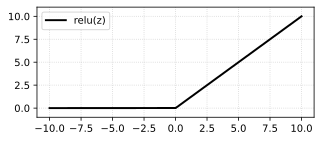

In [4]:
z = np.linspace(-10, 10, 1000)
plt.figure(figsize=(5, 2))
plt.plot(z, np.clip(z, a_min=0, a_max=None), label="relu(z)", linewidth=2, color="k")
plt.grid(alpha=0.6, linestyle="dotted"); plt.ylim(-1, 11); plt.legend();

### Fully-connected deep networks

Observe that for the 2-layer network, we have $|\Theta| = 2.$ A more generic form is the $L$-layer neural network, sometimes called a [multi-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP), **feedforward network** (FFN), or **fully-connected network** (FC) written in batch form as:

$$
h_\Theta(\mathbf{X}) = \sigma(\sigma(\ldots \sigma(\mathbf{X}\mathbf{W}_1)\mathbf{W}_2 \ldots) \mathbf{W}_{L-1}) \mathbf{W}_L
$$

or

$$
\begin{aligned}
\mathbf{Z}_0 &= \mathbf{X} \\
\mathbf{Z}_{i} &= \sigma_i (\mathbf{Z}_{i-1} \mathbf{W}_i), \quad \forall i = 1, \ldots, L \\
h_\Theta(\mathbf{X}) &= \mathbf{Z}_{L}
\end{aligned}
$$

where $\mathbf{Z}_i \in \mathbb{R}^{M \times d_i}$ and $\mathbf{W}_i \in \mathbb{R}^{d_{i-1} \times d_{i}}$, such that $d_0 = d$ and $d_{L} = K$ and $\sigma_i\colon \mathbb{R} \to \mathbb{R}$ applied elementwise, and weights $\Theta = \{ \mathbf{W}_1, \ldots, \mathbf{W}_L \}.$ It follows that $|\Theta| = L.$ Also, we typically set $\sigma_L = \text{Id}$ for the **output layer**.

**Remark.** Again a bias term can be added. But in theoretical analysis we can just think there is an extra column containing ones to simplify the computation. The index $i = 1, \ldots, L$ corresponds to the number of layers applied to the input. In particular, the output layer is indexed $L$ since we apply $L$ transformations to the input indexed $0.$ 

**Example.** Shapes for a 3-layer neural network which classifies inputs in $\mathbb{R}^{16}$ into $10$ classes:

<center>

| $i$  | $d_{i-1}$ | $d_{i}$ | PyTorch object |
| :-- | :--: | :--: | :-- |
| 1 |   16  |  32   | `Linear(16, 32)` | 
|2 |   32    |64   | `Linear(32, 64)` |
|3|    64|    10|   `Linear(64, 10)` | 

</center>

## Backpropagation

Recall that to train the linear function via softmax regression and SGD, we had to calculate the gradients across cross-entropy and the matrix product. For a deep neural network, we need to calculate the gradient for each $\mathbf{W}_i \in \Theta,$ i.e. across each layer $i = 1, 2, \ldots, L.$ Since the gradients are calculated from the loss to the inputs, this part of the computation is called **backward pass**. The algorithm for caching intermediate results and accumulating the gradients is collectively called **backpropagation** (BP) or simply "backprop".

The best way to understand and calculate backprop is to view neural nets as **computational graphs** with certain defined **operations** (e.g. entire layers, or lower-level tensor operations):

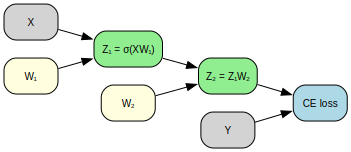

In [ ]:
#| label: fig-network-dag
#| code-fold: true
from graphviz import Digraph

dot = Digraph(format="png")
dot.attr(rankdir="LR")
dot.node_attr.update(shape="box", style="rounded,filled", fontsize="10", fontname="Helvetica")
dot.node("X", "X", fillcolor="lightgray")
dot.node("W1", "W₁", fillcolor="lightyellow")
dot.node("Z1", "Z₁ = σ(XW₁)", fillcolor="lightgreen")
dot.node("W2", "W₂", fillcolor="lightyellow")
dot.node("Z2", "Z₂ = Z₁W₂", fillcolor="lightgreen")
dot.node("loss", "CE loss", fillcolor="lightblue")
dot.node("Y", "Y", fillcolor="lightgrey")

dot.edges([("X", "Z1"), ("W1", "Z1"), ("Z1", "Z2"), ("W2", "Z2"), ("Z2", "loss"), ("Y", "loss")])
dot

### Gradients of a 2-layer NN

Let's work through softmax regression with a two-layer neural network. Our goal is to find $\nabla_{\mathbf{W}_i} \mathcal{L}_{\text{CE}}(h_\Theta(\mathbf{X}), \mathbf{y})$ for $i = 1, 2.$ Let's write this as $\mathbf{Z}_1 = \sigma(\mathbf{X} \mathbf{W}_1)$ and $\mathbf{Z}_2 = \mathbf{Z_1}\mathbf{W}_2.$ First, we branch towards the linear dependencies of $\mathbf{Z}_2$:

$$
\boxed{
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{Z}_2} 
&= \frac{1}{B} (\mathbf{P} - \mathbf{E}_\mathbf{y}) \\[0.75em]
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_2}
&= 
\frac{\partial \mathcal{L}}{\partial \mathbf{Z}_2}
\frac{\partial \mathbf{Z}_2}{\partial \mathbf{W}_2}
=
\frac{1}{B}\mathbf{Z}_1^\top (\mathbf{P} - \mathbf{E}_\mathbf{y}) \\[0.75em]
\frac{\partial \mathcal{L}}{\partial \mathbf{Z}_1} &=
\frac{\partial \mathcal{L}}{\partial \mathbf{Z}_2}
\frac{\partial \mathbf{Z}_2}{\partial \mathbf{Z}_1} = 
\frac{1}{B}
(\mathbf{P} - \mathbf{E}_\mathbf{y})
\mathbf{W}_2^\top.
\end{aligned}
}
$$

For the second equation, LHS has $(d_1, K)$, while RHS has $(d_1, B) \times (B, K)$. OK. The last formula is obtained by considering a single instance: ${\partial z_2^{j}}/{\partial z_1^{i}} = w^{ij}_2 = (w^\top_2)^{ji}.$ This has shape $(B, K) \times (K, d_1) = (B, d_1)$ which is expected. 

Next, we calculate the gradient across $\sigma.$ Here we are taking the derivative of $d_1$ functions with respect to the weight tensor of shape $(d, d_1).$ Let $\mathbf{U}_1 = \mathbf{X}\mathbf{W}_1$, so that $\mathbf{Z}_1 = \sigma(\mathbf{U}_1).$ Then,

$$
\begin{align*}
\frac{\partial {z}_1^j}{\partial w_1^{ik}} 
&= \sum_l 
\frac{\partial z_1^j}{\partial u_1^l}
\frac{\partial u_1^l}{\partial w_1^{ik}}  \\
&= \sum_l \delta^{jl} \sigma^\prime(u_1^l) \, x^i \delta^{lk} = \delta^{jk} \sigma^\prime(u_1^j) \, x^i. 
\end{align*}
$$ {#eq-dzdw}

Here $\delta =$ [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta). The two Kronecker delta "contracted" into one.
The effect of $\delta^{jk}$ is that $\sigma^\prime(u^j)$ essentially multiplies element-wise to the incoming gradient. Moreover, we aggregate the contribution of the batch instances by multiplying $\mathbf{X}^\top.$ Thus, in batch form:

$$
\boxed{
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_1} 
&= \frac{\partial \mathcal{L}}{\partial \mathbf{Z}_1} \frac{\partial \mathbf{Z}_1}{\partial \mathbf{W}_1} \\[0.7em]
&= \mathbf{X}^\top \left( \frac{\partial \mathcal{L}}{\partial \mathbf{Z}_1} \odot \sigma^\prime(\mathbf{X} \mathbf{W}_1) \right) \\[0.7em]
&= \frac{1}{B} \mathbf{X}^\top \Big( [(\mathbf{P} - \mathbf{E}_\mathbf{y})
\mathbf{W}_2^\top ] \odot \sigma^\prime(\mathbf{X} \mathbf{W}_1) \Big).
\end{aligned}
}
$$

### Graph visualization

Backward dependence can be inspected using the `torchviz` library. The graph shows the tensors being stored (🟧) during forward pass to compute the gradients. The weights (🟦) are instances of **leaf tensors**, i.e. the outermost nodes with no parent nodes. Hence, backward iteration stops at the leaf nodes. It follows that calculating gradients require:

- **twice** the memory of forward pass due to **caching**
- **same** time complexity $\mathcal{O}(S)$ where $S$ is the network size. 

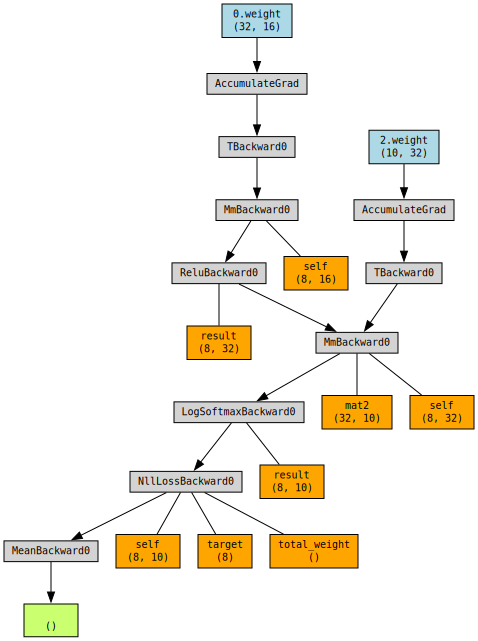

In [6]:
from torchviz import make_dot
import torch
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
    nn.Linear(16, 32, bias=False),
    nn.ReLU(),
    nn.Linear(32, 10, bias=False)
)

B = 8
x = torch.randn(B, 16)
z = model(x)
y = torch.randint(0, 10, size=(B,))
loss = F.cross_entropy(z, y)

make_dot(loss.mean(), params=dict(model.named_parameters()), show_saved=True)

### General formula for $L$-layers

For an $L$-layer network, we can traverse along the $\mathbf{Z}_i$'s to find $\partial{\mathcal{L}} / \partial{\mathbf{Z_i}}$ by taking the product with the local gradients $\partial{\mathbf{Z}_{i}}/\partial{\mathbf{Z}_{i-1}}.$ This can be thought of as traversing the main trunk of the network (@fig-network-dag). Meanwhile, the gradient for the weights (leaf tensors) can be calculated using the incoming gradients and $\partial{\mathbf{Z}_{i}}/\partial{\mathbf{W}_{i}}$ (see @eq-dzdw). Calculating $\partial{\mathbf{Z}_{i}}/\partial{\mathbf{Z}_{i-1}}$ can be done similarly  as follows. Observe that indices check out:

$$
\begin{aligned}
\frac{\partial {z}_i^j}{\partial {z}_{i-1}^k} 
&= \sum_l 
\frac{\partial {z}_i^j}{\partial u_i^l}
\frac{\partial u_i^l}{\partial {z}_{i-1}^k}  \\
&= \sum_l \delta^{jl} \sigma^\prime(u_i^l) \, w_{i}^{kl} = \sigma^\prime(u_i^j) \, ({w^\top})^{jk}. 
\end{aligned}
$$

Let $\mathbf{G}_{i} \coloneqq \frac{\partial{\mathcal{L}}}{\partial{\mathbf{Z}_{i}}}$ with shape $(B, d_{i}).$ Then for $i = L, \ldots, 1$:

$$
\boxed{
\begin{aligned}
\mathbf{G}_{L} &= \frac{1}{B}(\mathbf{P} - \mathbf{E}_\mathbf{y}) \quad \quad \;\text{(cross-entropy)} \\
\mathbf{G}_{i-1} &= 
    \mathbf{G}_{i} 
    \frac{\partial \mathbf{Z}_{i}}{\partial \mathbf{Z}_{i-1}} 
    = [
        \mathbf{G}_{i} \odot \sigma_i^\prime(\mathbf{Z}_{i-1} \mathbf{W}_i)
    ] \mathbf{W}_i^\top \\
\frac{\partial \mathcal{L}}{\partial \mathbf{W}_{i}} 
&= \mathbf{G}_{i} 
\frac{\partial \mathbf{Z}_{i}}{\partial \mathbf{W}_{i}}
= \mathbf{Z}_{i-1}^\top[\mathbf{G}_{i} \odot \sigma_i^\prime(\mathbf{Z}_{i-1} \mathbf{W}_i)]
\end{aligned}
}
$$

This looks very compact. You can verify that the shapes are correct and that the above derivation for two-layer networks is consistent with the current formulas with $\sigma_2 = \text{Id}.$ The formulas essentially describe the flow of gradients from the loss to the input. However, each update relies only on the gradients from the next layer.  

**Remark.** The gradients are modulated by gradient of the activation $\sigma_i$ (analogous to how activations squash linear outs during forward pass).
Observe the form `loss_grad x local_grad` where the loss gradient $\mathbf{G}_{i}$ from the next layer is, in a sense, "global" in contrast. This pattern is quite general as we will see later. Finally, the shape checks out: $(B, d_{i}) \times (d_{i}, d_{i-1}) = (B, d_{i-1}).$ Here $\mathbf{W}_i^\top$ projects vectors in $\mathbb{R}^{d_{i}}$ to $\mathbb{R}^{d_{i-1}}.$ On the other hand, $\mathbf{Z}_{i-1}^\top$ accumulates $M$ vectors in $\mathbb{R}^{d_{i}}$ for each of the $d_{i-1}$ coordinates.

$\blacksquare$

## Appendix: Gradient check using PyTorch

Calculating manually the gradients of a 3-layer neural network:

In [8]:
# network parameters
w1 = torch.randn(16, 64, requires_grad=True)
w2 = torch.randn(64, 32, requires_grad=True)
w3 = torch.randn(32, 10, requires_grad=True)

# forward pass
B  = 8
x  = torch.randn(B, 16)
z1 = torch.tanh(x @ w1)
z2 = torch.tanh(z1 @ w2)
z3 = z2 @ w3

for u in [w1, w2, w3, z1, z2, z3]:
    u.retain_grad()

h = z3
y = torch.randint(0, 10, size=(B,))
loss = F.cross_entropy(h, y)
loss.backward()

Backward pass:

In [ ]:
# walking down the trunk of the network
g3 = (F.softmax(h, dim=1) - F.one_hot(y, num_classes=10)) / B
g2 = g3 @ w3.T
g1 = (g2 * (1 - z2 ** 2)) @ w2.T

# branching to the leaf tensors (weights)
z0 = x
dw3 = z2.T @ g3
dw2 = z1.T @ (g2 * (1 - z2 ** 2))
dw1 = z0.T @ (g1 * (1 - z1 ** 2))

Note that shapes are equal, otherwise we can't subtract:

In [10]:
errors = []

errors.append(torch.abs(g3 - z3.grad).max().item())
errors.append(torch.abs(g2 - z2.grad).max().item())
errors.append(torch.abs(g1 - z1.grad).max().item())

errors.append(torch.abs(dw1 - w1.grad).max().item())
errors.append(torch.abs(dw2 - w2.grad).max().item())
errors.append(torch.abs(dw3 - w3.grad).max().item())

print(f"Max absolute error: {max(errors):.2e}")

Max absolute error: 1.19e-07


## Appendix: Universal approximation

[**Cybenko 1989**]. It turns out that any **continuous map** $f\colon \Omega \subset \mathbb{R}^d \to \mathbb{R}^m$ defined on a **compact set** $\Omega$ can be approximated by a 1-layer (wide) fully-connected network. Continuity on a compact domain is a reasonable assumption about a ground truth function that we assume exists. 

**Demo.** Approximating a one-dimensional curve with a ReLU network:

In [11]:
import torch

# Ground truth
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000)
y = torch.sin(x) + 0.3 * x

# Get sorted sample. Shifted for demo
B = sorted(torch.randint(30, 970, size=(24,)))
xs = x[B,]
ys = y[B,]

# ReLU approximation
z = torch.zeros(1000,) + ys[0]
for i in range(len(xs) - 1):
    if torch.isclose(xs[i + 1], xs[i]):
        m = torch.tensor(0.0)
    else:
        m = (ys[i+1] - ys[i]) / (xs[i+1] - xs[i])
    z += m * (torch.relu(x - xs[i]) - torch.relu(x - xs[i+1]))

**NOTE:** This only works for target $f$ with compact domain $[a, b]$ consistent with the theorem.

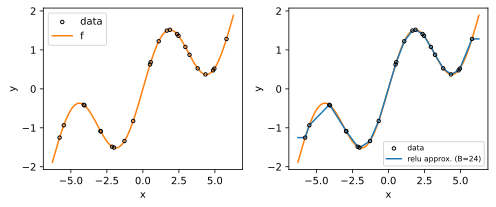

In [12]:
#| code-fold: true
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].scatter(xs, ys, facecolor="none", s=12, edgecolor="k", zorder=3, label="data")
ax[0].plot(x, y, color="C1", label="f")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].legend(loc="upper left")

ax[1].scatter(xs, ys, facecolor="none", s=12, edgecolor="k", zorder=4, label="data")
ax[1].plot(x, z, color="C0", label=f"relu approx. (B={len(B)})", zorder=3)
ax[1].plot(x, y, color="C1")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend(loc="lower right", fontsize=7.5)
fig.tight_layout();

## Appendix: Linearly separable features

An ideal classifier is that where the sequence of layers transform the input $\mathbf{x}_i \in \mathbb{R}^{d}$ into data points $F_{\Phi}(\mathbf{x}_i) \in \mathbb{R}^{d_{L-1}}$ that is linearly separable. That is, we essentially extend linear classification to input that is *not* linearly separable. This explains why the final layer has no activation, i.e. we can think of the network $f$ as

$$f_{(\Theta, \Phi)} = h_{\Theta} \circ F_{\Phi}$$

where $h_\Theta \colon \mathbb{R}^{L-1} \to \mathbb{R}^K$ is a linear hypothesis, while the earlier $L-1$ layers are feature extractors that compose $F_{\Phi}.$

**Demo.** Generating a dataset in $\mathbb{R}^2.$ Our goal is to separate this with a plane in $\mathbb{R}^3.$

In [13]:
import torch
torch.manual_seed(2)

def generate_data(M: int):
    noise = lambda e: torch.randn(M, 2) * e
    t = 2 * torch.pi * torch.rand(M, 1)
    s = 2 * torch.pi * torch.rand(M, 1)

    x0 = torch.cat([0.3 * torch.cos(s), 0.3 * torch.sin(s)], dim=1) + noise(0.2)
    x1 = torch.cat([3.0 * torch.cos(t), 3.0 * torch.sin(t)], dim=1) + noise(0.3)
    y0 = (torch.ones(M,) * 0).long()
    y1 = (torch.ones(M,) * 1).long()

    return x0, y0, x1, y1


x0, y0, x1, y1 = generate_data(1500)

Let's do a simple 2-layer neural net where the feature extractor maps to $\mathbb{R}^3$:

In [15]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 3), nn.Tanh(),
    nn.Linear(3, 2)
)

Model training:

In [16]:
import torch.nn.functional as F
from tqdm import tqdm

optim = torch.optim.SGD(model.parameters(), lr=0.01)

x = torch.cat([x0, x1])
y = torch.cat([y0, y1])
history = {"accs": [], "loss": []}
for step in tqdm(range(15000)):
    s = model(x)
    loss = F.cross_entropy(s, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    history["loss"].append(loss.item())
    history["accs"].append(100 * (y == torch.argmax(s, dim=1)).float().mean())

100%|██████████| 15000/15000 [00:07<00:00, 1898.47it/s]


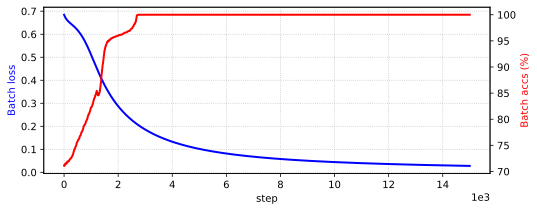

In [17]:
#| code-fold: true
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()

ax1.plot(history["loss"], color="blue", linewidth=2)
ax2.plot(history["accs"], color="red",  linewidth=2)
ax1.set_xlabel("step")
ax1.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax1.grid(axis="both", linestyle="dotted", alpha=0.8)

ax1.set_ylabel("Batch loss")
ax2.set_ylabel("Batch accs (%)")
ax1.yaxis.label.set_color("blue")
ax2.yaxis.label.set_color("red");

Observe that accuracy trend does not exactly match the steadily decreasing loss. This is expected since accuracy considers hard labels whereas the loss is calculated with respect to soft probability distributions.

In [18]:
#| code-fold: true
import warnings
warnings.filterwarnings("ignore")

# transformations
with torch.no_grad():
    linear_0 = model[0](x0)
    linear_1 = model[0](x1)
    linear_act_0 = model[1](model[0](x0))
    linear_act_1 = model[1](model[0](x1))

    # separating hyperplane (see above discussion, i.e. w <- w1 - w0  == logistic reg)
    h = 1
    w, b = model[2].parameters()
    w, b = (w[h] - w[h-1]), (b[h] - b[h-1])

# plot
fig = plt.figure(figsize=(8, 3))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132, projection="3d")
ax2 = fig.add_subplot(133, projection="3d")

ax0.grid(alpha=0.8, linestyle="dotted")
ax0.set_axisbelow(True)
ax0.scatter(x0[:, 0], x0[:, 1], s=2.0, label=0, color="C0")
ax0.scatter(x1[:, 0], x1[:, 1], s=2.0, label=1, color="C1")
ax0.set_xlabel("$x_1$")
ax0.set_ylabel("$x_2$")
ax0.set_xlim(-1.5, 1.5)
ax0.set_ylim(-1.5, 1.5)
ax0.set_title("(a) input")
ax0.legend()
ax0.set_facecolor("whitesmoke")
ax0.axis("equal")

ax1.scatter(linear_0[:, 0], linear_0[:, 1], linear_0[:, 2], s=3, label=0, color="C0", alpha=0.8)
ax1.scatter(linear_1[:, 0], linear_1[:, 1], linear_1[:, 2], s=3, label=1, color="C1", alpha=0.8)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_zlabel("$x_3$")
ax1.set_title("(b) linear")

ax2.scatter(linear_act_0[:, 0], linear_act_0[:, 1], linear_act_0[:, 2], s=3, label=0, color="C0")
ax2.scatter(linear_act_1[:, 0], linear_act_1[:, 1], linear_act_1[:, 2], s=3, label=1, color="C1")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.set_zlabel("$x_3$")
ax2.set_title("(c) linear + tanh")

# Generate grid of points
x_min = min(linear_act_1[:, 0].min(), linear_act_0[:, 0].min())
x_max = max(linear_act_1[:, 0].max(), linear_act_0[:, 0].max())
y_min = min(linear_act_1[:, 1].min(), linear_act_0[:, 1].min())
y_max = max(linear_act_1[:, 1].max(), linear_act_0[:, 1].max())
a, b, c, d = w[0], w[1], w[2], b
x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)
X, Y = np.meshgrid(x, y)
Z = (-a * X - b * Y - d) / c

# Plot the hyperplane for the positive class
ax2.plot_surface(X, Y, Z, alpha=0.5, color=f"C{h}")
fig.tight_layout();

**Remark.** The last linear layer (the "**logits**") defines the separating hyperplane.

Predicting on $\mathbb{R}^2$:

In [19]:
# Create a grid of points
N = 300
x = np.linspace(-6, 6, N)
y = np.linspace(-4, 4, N)
X, Y = np.meshgrid(x, y)

# Calculate p[1] for each point in grid
inp = torch.tensor(list(zip(X, Y)), dtype=torch.float32).permute(0, 2, 1).reshape(-1, 2)
out = F.softmax(model(inp), dim=1)
Z = out[:, 1].reshape(300, 300).detach().numpy()

The plot below is obtained by applying the model on each point in the grid. The coloring essentially represents the model on test data $\mathbf{x} \in \mathbb{R}^2$. Notice that we essentially have a nonlinear decision boundary:

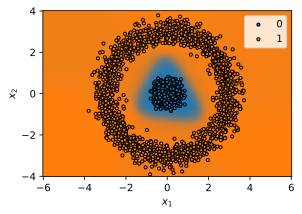

In [20]:
#| code-fold: true
# create a color plot
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap
colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

fig = plt.figure(figsize=(6, 3))
plt.pcolormesh(X, Y, Z, shading="auto", cmap=cm, rasterized=True)
plt.xlabel("X")
plt.ylabel("Y")

plt.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black")
plt.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.gca().set_aspect("equal", adjustable="box");